#Arima



## Importación de librerías y datos

Por medio de nuestra libería ESIOS_contoller.py importamos nuestro último dataset de datos y lo parseamos para su uso. Sirve tanto como para Drive como jupiter.

In [22]:
import json, urllib, datetime, pickle, time
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import *
from keras.models import *
from keras.layers import *
from sklearn.preprocessing import *
from keras.optimizers import *
from scipy.stats import *
from importlib.machinery import SourceFileLoader


try:
  from google.colab import drive
  drive.mount('/content/drive')
  path = '/content/drive/My Drive/TFM/01.Utils/ESIOS_contoller.py'
  in_colab = True
except:
  path = '../utils/ESIOS_contoller.py'
  in_colab = False
  

esios_assembler = SourceFileLoader('esios', path).load_module()

esios_controller = esios_assembler.ESIOS(in_colab)
data_consumo = esios_controller.get_data('non-secuencial')

Mounted at /content/drive
Mostrando los datos de data_total_for_non_serial.csv
(30555, 34)
________________________________________________________________________________


## Preparación de los datos

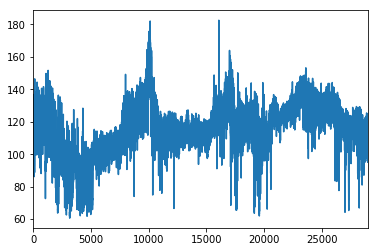

In [8]:
from matplotlib import pyplot
from sklearn.model_selection import train_test_split

data = data_consumo[['date_timestamp', 'PVPC_DEF']]

train, test = train_test_split(data, test_size=0.05, random_state=0, shuffle=False)
train_short, test_short = train_test_split(data, test_size=0.002, random_state=0, shuffle=False)

train['PVPC_DEF'].plot()
pyplot.show()

In [9]:
print(test_short.shape)
print(train.shape)

(62, 2)
(29027, 2)


Viendo esta correlación y las inferiores parece haber correlación entre los datos de **hace un día** y de **hace un año**

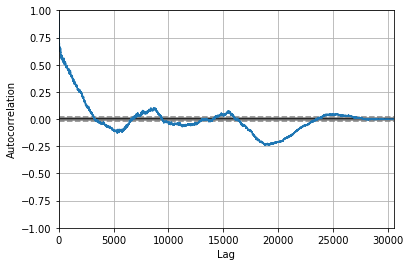

In [10]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(data.PVPC_DEF)
pyplot.show()

## Modelo simple (ARIMA)

In [0]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame

model = ARIMA(np.asarray(train.PVPC_DEF), order=(5,1,4))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                29026
Model:                 ARIMA(5, 1, 4)   Log Likelihood              -78356.572
Method:                       css-mle   S.D. of innovations              3.599
Date:                Thu, 10 Oct 2019   AIC                         156735.143
Time:                        12:43:13   BIC                         156826.179
Sample:                             1   HQIC                        156764.399
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0003      0.004     -0.082      0.935      -0.008       0.007
ar.L1.D.y      1.8870      0.011    167.792      0.000       1.865       1.909
ar.L2.D.y     -0.4316      0.025    -17.013      0.0

### Análisis residuo

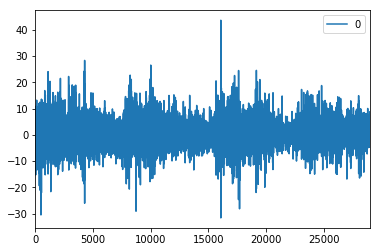

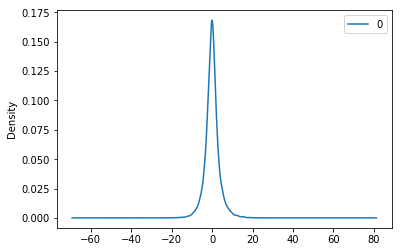

                  0
count  29026.000000
mean      -0.000217
std        3.598836
min      -31.648258
25%       -1.756795
50%       -0.068029
75%        1.613147
max       43.598983


In [0]:
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()

print(residuals.describe())

In [0]:
from statsmodels.stats.diagnostic import acorr_ljungbox

LBBP_df = pd.DataFrame(np.column_stack(acorr_ljungbox(model_fit.resid,boxpierce=True,  lags=12)),
             columns=['LB_statistic','LB_pvalue', 'BP_statistic','BP_pvalue'])

print(LBBP_df)

    LB_statistic     LB_pvalue  BP_statistic     BP_pvalue
0       0.071671  7.889185e-01      0.071664  7.889291e-01
1       0.071943  9.646679e-01      0.071935  9.646715e-01
2       1.214209  7.495984e-01      1.214005  7.496473e-01
3       3.061799  5.475372e-01      3.061213  5.476343e-01
4       6.393833  2.697605e-01      6.392443  2.698827e-01
5      12.971040  4.349815e-02     12.967837  4.354954e-02
6      14.918809  3.705436e-02     14.915003  3.710451e-02
7     125.203001  2.786698e-23    125.161202  2.842748e-23
8     152.000423  3.395702e-28    151.948470  3.480955e-28
9     153.997089  5.604376e-28    153.944310  5.746461e-28
10    155.012061  1.407123e-27    154.958828  1.442877e-27
11    155.099956  5.220874e-27    155.046681  5.352736e-27


### Predicción 24 h
SI predecimos sólo el día de mañana hora a hora
No tiene mucho valor para la muestra, debemos intentar predecir un día entero 


In [0]:
from math import sqrt
from sklearn.metrics import mean_squared_error

predictions = list()
predictions_real = list()
days_to_predict = 24
history = train_short.PVPC_DEF.values.tolist()
test_list = test_short.PVPC_DEF.values.tolist()

for iter_t in range(0, len(test_list), days_to_predict):
    history_temp = history.copy()
  
    weekly_pred = list()
    weekly_pred_real = list()
    for t in range(days_to_predict):
        if np.shape(test_list)[0] <= (iter_t + t):
            break
        
        model = ARIMA(history_temp, order=(5,1,4))  
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]

        history_temp.append(yhat[0])
        weekly_pred.append(yhat[0])
        weekly_pred_real.append(test_list[iter_t + t])
    
    predictions.append(weekly_pred)  
    predictions_real.append(weekly_pred_real) 
    
    history.extend(test_list[iter_t : iter_t + days_to_predict])
    
    if iter_t%10 == 0:
        print(weekly_pred)
        print(weekly_pred_real)

[106.19827675715044, 106.2496902882691, 107.52811589382978, 109.0409133131915, 110.41790656233478, 111.11284346536347, 111.15288304407945, 110.42445340811437, 109.35021241092475, 108.10807263429382, 107.22451383506898, 106.7919530223441, 107.07806277377465, 107.83722722085929, 109.00000684523178, 110.0926666494162, 110.96929065476105, 111.26083069101428, 111.05633213840386, 110.2965247381136, 109.35297847059806, 108.35887679929003, 107.72476851401562, 107.4794239448171]
[101.31, 100.54, 100.9, 110.91, 116.41, 114.26, 113.77, 115.77, 110.74, 106.74, 106.0, 105.1, 106.0, 106.66, 105.58, 106.97, 109.7, 104.77, 105.53, 100.37, 99.17, 98.99, 99.08, 99.1]


In [0]:
predictions_res = list()
predictions_real_res = list()

for i in range((np.shape(predictions)[0]-1)):
    predictions_res.extend(predictions[i])
    predictions_real_res.extend(predictions_real[i])

print(np.shape(predictions_res))
print(np.shape(predictions_real_res))

(48,)
(48,)


### Métricas

In [0]:
test_list = np.reshape(test_list, (np.shape(test_list)[0]))

esios_controller.get_metrics(pd.DataFrame(predictions_real_res), pd.DataFrame(predictions_res))

** --------------- Metrics: --------------- **
MSE:  30.636808936863826
RMSE:  5.535052749239507
MAE:  4.709325675303392
Log_MSE:  0.002640977003943099
MedianAE:  4.019047714948137
MAPE:  0    4.418415
dtype: float64 %
SMAPE:  0    4.400351
dtype: float64 %
Variance:  -0.06569270046764131
Max Error:  10.182978470598059
** ---------------------------------------- **


### PLOT

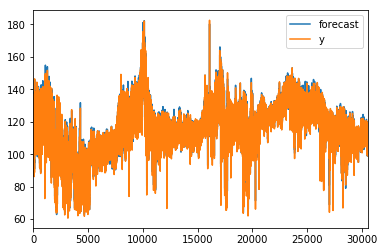

In [0]:
var = model_fit.plot_predict(dynamic=False)

## Auto Arima


In [0]:
!pip install -q pmdarima
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(train.PVPC_DEF, start_p=1, start_q=1, test='adf',max_p=48, max_q=5,m=1, d=None, seasonal=True,  
                      start_P=0, D=0, trace=True,error_action='ignore', suppress_warnings=True, stepwise=True)

print(model.summary())


Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=160610.396, BIC=160643.500, Fit time=10.435 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=243597.170, BIC=243613.722, Fit time=0.793 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=164235.578, BIC=164260.406, Fit time=1.763 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=210426.959, BIC=210451.787, Fit time=7.553 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=160377.120, BIC=160418.500, Fit time=16.204 seconds
Fit ARIMA: order=(2, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=160483.120, BIC=160516.223, Fit time=2.420 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=160316.495, BIC=160366.151, Fit time=42.394 seconds
Fit ARIMA: order=(3, 0, 3) seasonal_order=(0, 0, 0, 1); AIC=160441.461, BIC=160507.669, Fit time=63.342 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=160314.537, BIC=160355.917, Fit time=15.766 seco

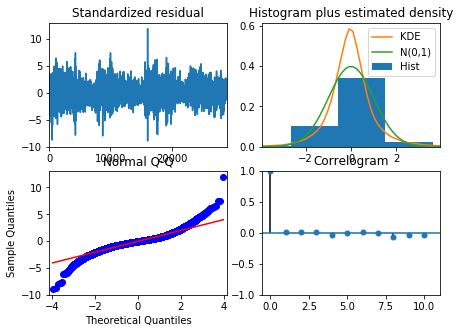

In [0]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

##  SARIMAX

In [0]:
import statsmodels.api as sm

mod = sm.tsa.statespace.SARIMAX(train_short.PVPC_DEF, seasonal_order=(4,0,1, 12))
model_fitted = mod.fit(disp=False)
print(model_fitted.summary())

                                 Statespace Model Results                                 
Dep. Variable:                           PVPC_DEF   No. Observations:                30493
Model:             SARIMAX(1, 0, 0)x(4, 0, 1, 12)   Log Likelihood              -85544.772
Date:                            Fri, 11 Oct 2019   AIC                         171103.544
Time:                                    08:36:53   BIC                         171161.820
Sample:                                         0   HQIC                        171122.228
                                          - 30493                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9994      0.000   3279.552      0.000       0.999       1.000
ar.S.L12       1.1024      0.014   

### Análisis residuo

NormaltestResult(statistic=13466.617111887615, pvalue=0.0)


Text(0.5, 1.0, 'Residual distribution')

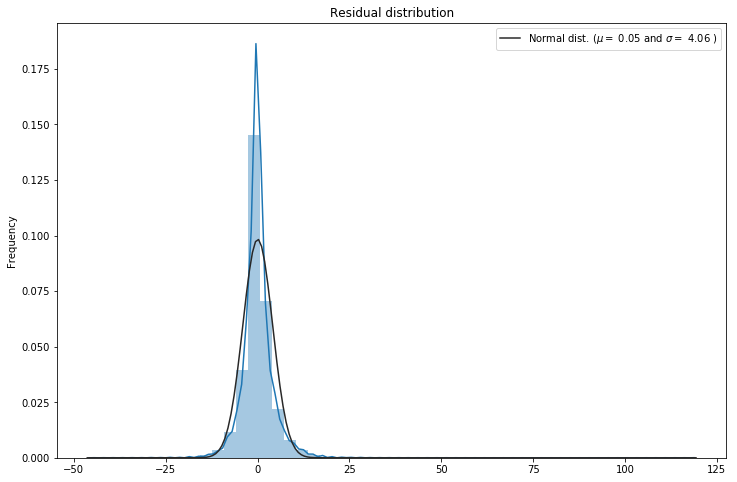

In [0]:
from scipy import stats
from scipy.stats import normaltest

resid = model_fitted.resid
print(normaltest(resid))

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

(mu, sigma) = stats.norm.fit(resid)

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')

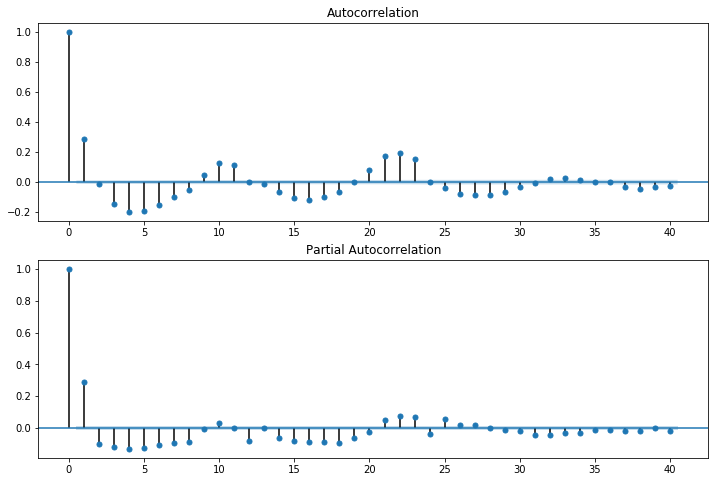

In [0]:
# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(model_fitted.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(model_fitted.resid, lags=40, ax=ax2)

In [0]:
from statsmodels.stats.diagnostic import acorr_ljungbox
LBBP_df = pd.DataFrame(np.column_stack(acorr_ljungbox(model_fitted.resid,boxpierce=True,  lags=25)),
             columns=['LB_statistic','LB_pvalue', 'BP_statistic','BP_pvalue'])

print(LBBP_df)

    LB_statistic  LB_pvalue  BP_statistic  BP_pvalue
0    2500.238422        0.0   2499.992457        0.0
1    2505.779676        0.0   2505.532984        0.0
2    3139.347180        0.0   3138.996607        0.0
3    4315.176276        0.0   4314.594354        0.0
4    5480.046990        0.0   5479.197677        0.0
5    6204.618816        0.0   6203.579421        0.0
6    6513.599720        0.0   6512.469135        0.0
7    6598.474336        0.0   6597.315918        0.0
8    6672.624053        0.0   6671.438889        0.0
9    7156.216466        0.0   7154.841005        0.0
10   7541.045988        0.0   7539.506475        0.0
11   7541.059549        0.0   7539.520029        0.0
12   7544.931871        0.0   7543.390446        0.0
13   7674.442562        0.0   7672.833186        0.0
14   8034.637736        0.0   8032.827563        0.0
15   8444.042124        0.0   8441.990295        0.0
16   8731.007156        0.0   8728.776533        0.0
17   8863.679025        0.0   8861.361389     

### Predicción 24h

In [0]:
predictions = list()
predictions_real = list()
days_to_predict = 24
history = train_short.PVPC_DEF.values.tolist()
test_list = test_short.PVPC_DEF.values.tolist()

for iter_t in range(0, len(test_list), days_to_predict):
    history_temp = history.copy()
  
    weekly_pred = list()
    weekly_pred_real = list()
    for t in range(days_to_predict):
        if np.shape(test_list)[0] <= (iter_t + t):
            break
        
        model = sm.tsa.statespace.SARIMAX(history, seasonal_order=(4,0,0, 12))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]

        history_temp.append(yhat)
        weekly_pred.append(yhat)
        weekly_pred_real.append(test_list[iter_t + t])
    
    predictions.append(weekly_pred)  
    predictions_real.append(weekly_pred_real) 
    
    history.extend(test_list[iter_t : iter_t + days_to_predict])
    
    if iter_t%10 == 0:
        print(weekly_pred)
        print(weekly_pred_real)


In [0]:
predictions_res = list()
predictions_real_res = list()

for i in range((np.shape(predictions)[0]-1)):
    predictions_res.extend(predictions[i])
    predictions_real_res.extend(predictions_real[i])

print(np.shape(predictions_res))
print(np.shape(predictions_real_res))

(48,)
(48,)


### Métricas

In [0]:
test_list = np.reshape(test_list, (np.shape(test_list)[0]))

esios_controller.get_metrics(pd.DataFrame(predictions_real_res), pd.DataFrame(predictions_res))

** --------------- Metrics: --------------- **
MSE:  60.766127119358494
RMSE:  7.795263120598207
MAE:  6.386384862820232
Log_MSE:  0.005280037653935708
MedianAE:  6.847334842845946
MAPE:  0    5.830818
dtype: float64 %
SMAPE:  0    6.026373
dtype: float64 %
Variance:  -0.5237005505686898
Max Error:  14.795915189742843
** ---------------------------------------- **


### Plot

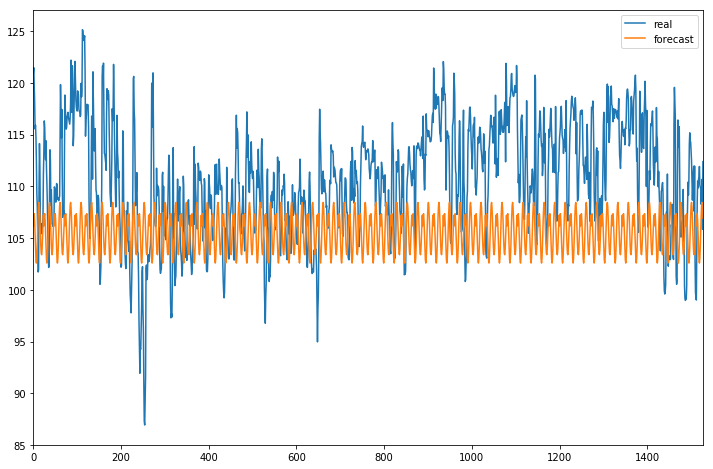

In [0]:
d = {'real':predictions_real_res,'forecast':predictions_res}
df = pd.DataFrame(d)
df.plot(figsize=(12, 8))

## ARIMA diario

In [11]:
x_data_grouped = esios_controller.get_df_daily()

x_data_grouped = pd.DataFrame(x_data_grouped['PVPC_DEF'])

train, test = train_test_split(x_data_grouped, test_size=0.05, random_state=0, shuffle=False)

print('Xtrain_dim:', train.shape)
print('Ytrain_dim:', test.shape)

Xtrain_dim: (1330, 1)
Ytrain_dim: (71, 1)


In [12]:
!pip install -q pmdarima
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(x_data_grouped['PVPC_DEF'], start_p=1, start_q=1, test='adf',max_p=48, max_q=5,m=1, seasonal=False,  
                      start_P=0, D=1, trace=True,error_action='ignore', suppress_warnings=True, stepwise=True)

print(model.summary())


     |████████████████████████████████| 1.1MB 2.9MB/s 
Fit ARIMA: order=(1, 0, 1); AIC=9043.082, BIC=9064.062, Fit time=0.255 seconds
Fit ARIMA: order=(0, 0, 0); AIC=11437.204, BIC=11447.694, Fit time=0.003 seconds
Fit ARIMA: order=(1, 0, 0); AIC=9042.824, BIC=9058.559, Fit time=0.045 seconds
Fit ARIMA: order=(0, 0, 1); AIC=10184.907, BIC=10200.641, Fit time=0.069 seconds
Fit ARIMA: order=(2, 0, 0); AIC=9044.277, BIC=9065.257, Fit time=0.087 seconds


KeyboardInterrupt: ignored

### Modelo

In [13]:
from statsmodels.tsa.arima_model import ARIMA

history = train.values.tolist()
test_list = test.values.tolist()
predictions = list()

print(np.shape(history))
print(history)

for value in test_list:
  model = ARIMA(history, order=(4,1,4))
  model_fit = model.fit(disp=0)
    
  yhat = model_fit.forecast()[0][0]
  predictions.append(yhat)
  history.append(value)
  print(np.shape(history))
  print(history)

(1330, 1)
[[117.43], [124.59857142857142], [122.74695652173914], [114.16166666666668], [101.12083333333335], [106.64], [112.275], [123.67842105263155], [123.02478260869567], [122.66125], [113.27375], [112.45375000000001], [112.88333333333333], [117.25333333333333], [116.0227272727273], [121.87428571428572], [124.67681818181823], [109.37380952380951], [113.64947368421053], [120.86631578947369], [112.67904761904761], [115.37450000000001], [118.08833333333334], [122.69150000000002], [115.15636363636364], [108.1105], [116.62130434782608], [112.28263157894736], [107.46315789473682], [116.8985714285714], [111.67900000000002], [110.61739130434783], [97.66318181818183], [112.398], [117.96416666666669], [119.68714285714285], [119.28823529411764], [122.58238095238093], [118.07409090909091], [109.61933333333333], [128.40666666666667], [128.43578947368422], [128.91928571428573], [129.33375], [123.97761904761907], [118.21950000000001], [115.86857142857144], [126.30190476190475], [124.9242857142857]

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


(1400, 1)
[[117.43], [124.59857142857142], [122.74695652173914], [114.16166666666668], [101.12083333333335], [106.64], [112.275], [123.67842105263155], [123.02478260869567], [122.66125], [113.27375], [112.45375000000001], [112.88333333333333], [117.25333333333333], [116.0227272727273], [121.87428571428572], [124.67681818181823], [109.37380952380951], [113.64947368421053], [120.86631578947369], [112.67904761904761], [115.37450000000001], [118.08833333333334], [122.69150000000002], [115.15636363636364], [108.1105], [116.62130434782608], [112.28263157894736], [107.46315789473682], [116.8985714285714], [111.67900000000002], [110.61739130434783], [97.66318181818183], [112.398], [117.96416666666669], [119.68714285714285], [119.28823529411764], [122.58238095238093], [118.07409090909091], [109.61933333333333], [128.40666666666667], [128.43578947368422], [128.91928571428573], [129.33375], [123.97761904761907], [118.21950000000001], [115.86857142857144], [126.30190476190475], [124.9242857142857]

### Análisis residuo

                 0
count  1399.000000
mean     -0.000941
std       5.445496
min     -29.970142
25%      -2.643738
50%       0.241942
75%       3.049752
max      23.725841


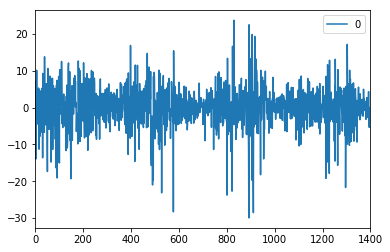

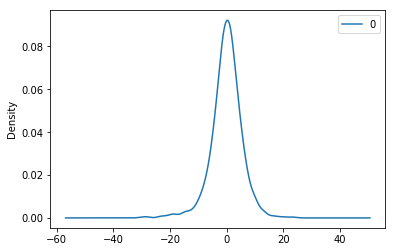

In [14]:
from pandas import DataFrame

residuals = DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')

print(residuals.describe())

### Metrics

Algunas métricas de otros modelos ejecutados:

ARIMA (4,0,4)
RMSE: 3.08
MAPE: 2.13 % 
SMAPE: 2.11 %

ARIMA (4,1,4)
RMSE: 2.60
MAPE: 1.84 % 
SMAPE: 1.83 %

ARIMA (7,1,4)
RMSE: 2.82
MAPE: 1.94 % 
SMAPE: 1.93 %

ARIMA (8,1,8)
RMSE: 2.61
MAPE: 1.88 % 
SMAPE: 1.87 %

In [15]:
esios_controller.get_metrics(pd.DataFrame(test_list), pd.DataFrame(predictions))

** --------------- Metrics: --------------- **
MSE:  9.30834472160837
RMSE:  3.0509580006300268
MAE:  2.328942874347818
Log_MSE:  0.0007479006933584434
MedianAE:  1.8903877555792832
MAPE:  0    2.11443
dtype: float64 %
SMAPE:  0    2.104926
dtype: float64 %
Variance:  0.4413947064256398
Max Error:  9.467168042664312
** ---------------------------------------- **


### Predicción 24h

In [16]:
np.shape(pd.DataFrame(predictions))

(71, 1)

In [21]:
predictions = pd.DataFrame(predictions)
predictions['Holiday'] = esios_controller.get_df_daily()[-71:]['Holiday'].values
np.shape(predictions)

(71, 2)

In [23]:
encoder = esios_controller.load_keras_model('/content/drive/My Drive/TFM/01.Utils/data/Encoder.json')

/content/drive/My Drive/TFM/01.Utils/data/Encoder.json








Loaded model from disk


In [24]:
all_day_real_preds = encoder.predict(predictions);
print(np.shape(all_day_real_preds))

(71, 24)


In [25]:
y_data_target = esios_controller.get_df_daily_target_day_prics()
y_data_target = pd.DataFrame(y_data_target.values.tolist(), columns=['h'+str(i) for i in range(24)])

y_data_target_for_test = y_data_target[-71:]
np.shape(y_data_target_for_test)

(71, 24)

In [26]:
import math
pred = list()
real = list()

day_key = 0
for day in y_data_target_for_test.values:
  hour_key = 0
  for hour in day:
    if not math.isnan(hour) and hour != 0:
      real.append(hour)
      pred.append(all_day_real_preds[day_key][hour_key])
    hour_key += 1 
  day_key += 1  
  
  
print(np.shape(pred))
print(np.shape(real)) 

(1627,)
(1627,)


### Métricas

In [27]:
esios_controller.get_metrics(pd.DataFrame(real), pd.DataFrame(pred))

** --------------- Metrics: --------------- **
MSE:  38.842987927658875
RMSE:  6.232414293647276
MAE:  4.830121187234702
Log_MSE:  0.003164266837312521
MedianAE:  3.8496066284179733
MAPE:  0    4.424166
dtype: float64 %
SMAPE:  0    4.379676
dtype: float64 %
Variance:  -0.22128778880568678
Max Error:  23.73665924072266
** ---------------------------------------- **


### Plot

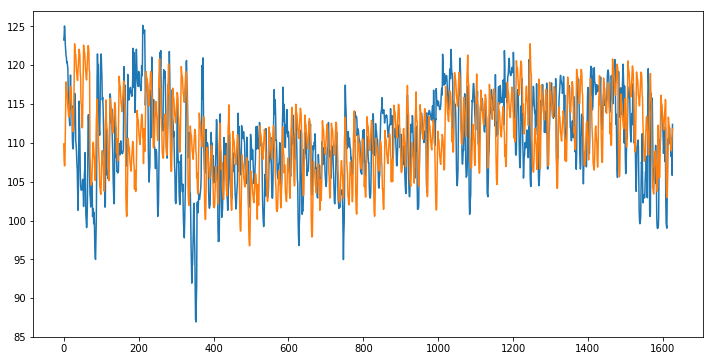

In [0]:
plt.figure(figsize=(12, 6))
last_non_0 = np.shape(pred)[0] - 24

plt.plot(real[:last_non_0], label='real data')
plt.plot(pred[:last_non_0], label='pred data') 

## Resultados

### ARIMA 

MSE:  30.636808936863826

RMSE:  5.535052749239507

MAPE: 4.418415 %

SMAPE: 4.400351 %

### SARIMAX

MSE:  60.766127119358494

RMSE:  7.795263120598207

MAPE: 5.830818 %

SMAPE:  6.026373 %


### ARIMA diario

MSE:  207.34532043352567

RMSE:  14.399490283809552

MAPE:  0    inf

SMAPE:  0    7.223378
